# Malaria Cell Detection

This R-CNN model is trained to detect the location of malaria cells in images.

### Dependencies 

In [ ]:
pip install torch numpy matplotlib pandas==1.3 tensorflow-macos tensorflow-datasets opencv-python pillow

### Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display
from PIL import Image
import random

## Loading the Data

Getting the malaria dataset from the tensorflow library and loading it into a DataLoader from torch. 


In [149]:
# Getting the malaria dataset from the tensorflow library and loading it into a DataLoader from torch. 
malaria_ds = tfds.load(
    'malaria', 
    split='train', 
    as_supervised=True, 
    with_info=True,
    download=False,
    data_dir="~/tensorflow_datasets")
df = tfds.as_dataframe(malaria_ds[0], malaria_ds[1])

In [156]:
print(df["image"][0])

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [2]:
data_dir = '../data/malaria_df.pickle'

In [5]:
import pickle 
with open(data_dir, 'wb') as f:
    pickle.dump(df, f)

In [14]:

df = pd.read_pickle(data_dir)

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
(27558, 2)


### Preview Samples

Have a look at the samples: 

In [81]:
def show_malaria_image(image, label): 
    plt.imshow(image, cmap='gray')
    plt.title("Uninfected" if label else "Infected", loc='center')
    plt.ylabel(f"Height ({image.shape[0]})")
    plt.xlabel(f"Width ({image.shape[1]})")
    plt.show()

In [82]:
def show_samples(samples):
    x = int(len(samples) / 2)
    y = len(samples) - x
    for i in range(len(samples)):
        plt.subplot(x, y, i + 1)
        plt.subplots_adjust(hspace=1)
        plt.imshow(samples[i][0], cmap='gray')
        plt.title("Uninfected" if samples[i][1] else "Infected", loc='center')
        plt.ylabel(f"Height ({samples[i][0].shape[0]})")
        plt.xlabel(f"Width ({samples[i][0].shape[1]})")
    plt.show()

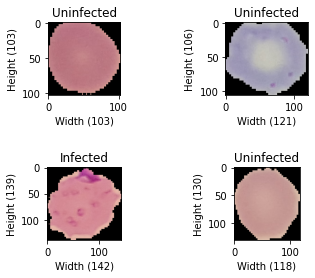

In [37]:
show_samples(df[:4].values)

### Exploring the Data

We now perform a quick exploration of the data.

Number of different shapes:  1627


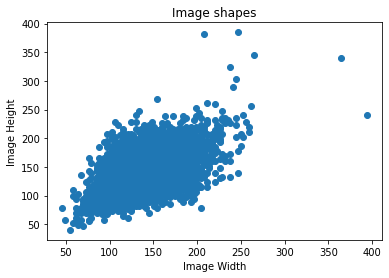

In [10]:
shapes = []
outliers = []
for image, label in zip(df["image"], df["label"]):
    if image.shape not in shapes: 
        shapes.append(image.shape)
    if image.shape[0] > 300 or image.shape[1] > 300:
        outliers.append((image, label))

print("Number of different shapes: ", len(shapes))

# create a scatter plot of the different shapes
plt.title("Image shapes")
plt.scatter(x=[shape[1] for shape in shapes],y=[shape[0] for shape in shapes])
plt.ylabel("Image Height")
plt.xlabel("Image Width")
plt.show()

In [ ]:
print(f"There are {len(outliers)} images with a width or height greater than 300")
outlier_shapes = np.array([img[0].shape for img in outliers])
table = pd.DataFrame(data=outlier_shapes[:,:2], columns=["Height", "Width"])
display(table)

index = int(input("Enter the number of the image to show: "))
assert index < len(outliers)
show_malaria_image(outliers[index][0], outliers[index][1])

## Data Augmentation

We will use the following transforms to augment the data:

* Resize the data for the model
* Random rotation and zoom
* Width and height 
* Shear intensity
* Horizontal flip

### Resizing the Images

We can use the PIL library to resize the images to a fixed size.

In [78]:
# Function to resize the image
def resize(image, size): 
    resized = Image.fromarray(image).resize(size, resample=Image.BOX)
    return np.array(resized)

See how large images will be after resizing:

In [ ]:
# See the image before and after resizing
index = int(input("Enter the number of the image to resize: "))
print(f"Outlier {index} before resize: {outlier_shapes[index]}")
show_malaria_image(outliers[index][0], outliers[index][1])
# See how the large images with unequal proportions are resized
resized_image = resize(outliers[index][0], (150, 150))
print(f"Outlier {index} after resize: {resized_image.shape}")
show_malaria_image(resized_image, outliers[index][1])

See how small images will be after resizing:

In [ ]:
# Get small images with width and height smalles than 70
small_images = [(image, label) for (image, label) in zip(df["image"], df["label"]) if image.shape[0] < 70 and image.shape[1] < 70]
print(f"There are {len(small_images)} images with a width and height smaller than 70")
small_shapes = np.array([img[0].shape for img in small_images])
table = pd.DataFrame(data=small_shapes[:,:2], columns=["Height", "Width"])
display(table)
# See how the small images are after resizing
index = int(input("Enter the number of the image to show: "))
assert index < len(small_images)
show_malaria_image(small_images[index][0], small_images[index][1])
resized_img = resize(small_images[index][0], (150, 150))
print("After resizing to (150, 150):")
show_malaria_image(resized_img, small_images[index][1])

Resizing all the images: 

In [117]:
# resize all the images and store back into df
df["image"] = df["image"].apply(lambda x: resize(x, (64, 64)))

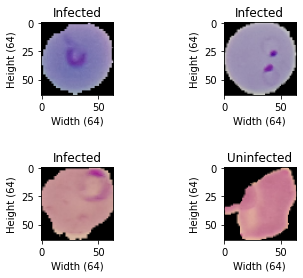

In [118]:
# get list of 4 random number within len(df)
indexes = random.sample(range(len(df)), 4)
show_samples(df.iloc[indexes].values)

### Splitting the Data

We will split the data into training and validation. 

In [119]:
np_df = df.to_numpy()
np.random.seed(1000)
np.random.shuffle(np_df)
df_trn = np_df[:int(len(np_df) * 0.8)]
df_val = np_df[int(len(np_df) * 0.8):]

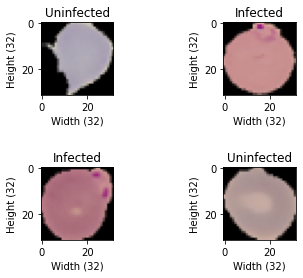

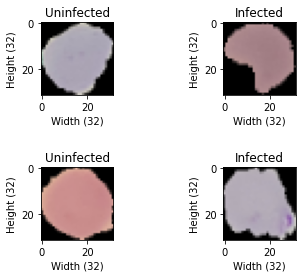

In [86]:
show_samples(df_trn[:4])
show_samples(df_val[:4])

### Data Loader

Now that the data is ready, we can use create a DataLoader that will be used for training.

In [120]:
class MalariaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.n_samples = len(dataframe)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        image, label = self.dataframe[index]
        if self.transform: 
            image = self.transform(image)
        return image, label

In [121]:
batch_size = 32
train_dataset = MalariaDataset(df_trn, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = MalariaDataset(df_val, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Let's check that the data loader is working properly:

In [ ]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}")
    print(images.shape)
    show_samples([[np.transpose(image.numpy(),(2, 1, 0)), label] for (image, label) in zip(images, labels)])
    if i == 2: 
        break

# Model Architecture

The model architecture is as follows:
* CNN model with FC layers
* Convolutional 3x3 layers
* Maxpool 2x2
* Fully connected layers
* Activation function: ReLU

### Defining the Model

We use the nn.Module class to define the model.

In [132]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        # 32 -> 30 -> 15 -> 13 -> 06 -> 04 -> 02
        # 64 -> 62 -> 31 -> 29 -> 14 -> 12 -> 06
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 16, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 12, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(12 * 6 * 6, 512),
            nn.ReLU(),
            nn.Linear(512, 64), 
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x): 
        output = self.conv_layers(x)
        # print(output.size())
        output = output.view(-1, 12 * 6 * 6)
        output = self.fc_layers(output)
        return output

In [129]:
learning_rate = 0.001

model = CNN()

loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Check that the model architecture is correct:

In [101]:
for i, (images, labels) in enumerate(train_loader):
    # ensure labels are same size and type
    labels = labels.unsqueeze(1).float()
    outputs = model(images)
    loss_value = loss(outputs, labels)
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()
    break

torch.Size([128, 12, 4, 4])


## Training the Model



In [124]:
num_steps = len(train_loader)
print(len(df_trn), num_steps)

22046 689


In [125]:
def evaluate(model, loader): 
    total_err = 0
    total_samples = 0
    for images, labels in loader: 
        total_err += int(((model(images) > 0.0).squeeze().long() != labels).sum())
        total_samples += len(labels)
    return float(total_err) / total_samples

In [126]:
import pathlib
model_path = pathlib.Path(f"models/malaria_bs{batch_size}_lr{learning_rate}")
model_path.mkdir(parents=True, exist_ok=True)

In [ ]:
torch.manual_seed(1000)
num_epochs = 50

train_loss = np.zeros(num_epochs)
val_error = np.zeros(num_epochs)

for epoch in range(num_epochs):
    running_loss = 0 
    for images, labels in train_loader: 
        # ensure labels are same size and type
        labels = labels.unsqueeze(1).float()
        # forward pass
        outputs = model(images)
        loss_value = loss(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        # for statistics
        running_loss += loss_value.item()
    # compute average loss 
    train_loss[epoch] = running_loss / num_steps
    # evaluate on validation set
    val_error[epoch] = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_value.item():.6f}, Validation Error: {val_error[epoch]:.6f}")
    # save model after each epoch
    torch.save(model.state_dict(), model_path / f"epoch_{epoch+1}")

# show total loss
plt.title("Total Loss")
plt.plot(range(1, len(train_loss) + 1), train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.title("Validation Error")
plt.plot(range(1, len(val_error) + 1), val_error)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Evaluating the Model

We can now test the model on the validation set.

Validation Accuracy: 0.9568
Number of Incorrect Images: 238


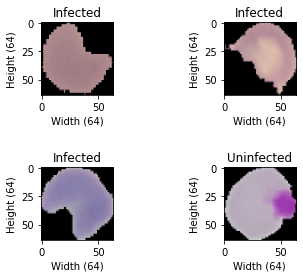

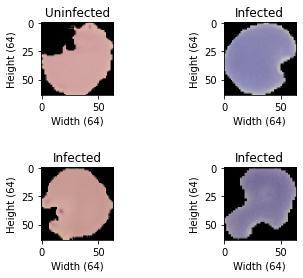

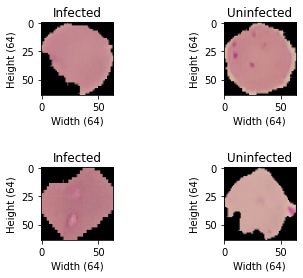

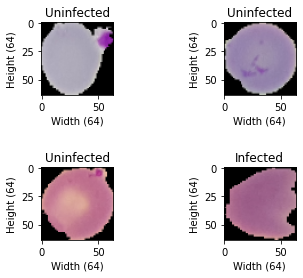

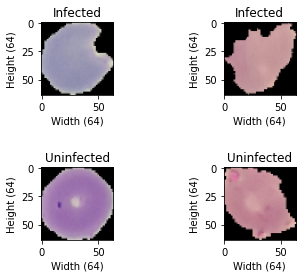

In [145]:
net = CNN()
state = torch.load('models/best_models/epoch_4')
net.load_state_dict(state)

incorrect = []
total_correct = 0
for images, labels in val_loader: 
    output = (net(images) > 0.0).squeeze().long()
    for pred, label, image in zip(output, labels, images): 
        if pred != label: incorrect.append((image, label))
        else: total_correct += 1
accuracy = float(total_correct) / len(df_val)
print(f"Validation Accuracy: {accuracy:.4f}")

incorrect = [[np.transpose(image.numpy(),(2, 1, 0)), label] for (image, label) in incorrect]
print(f"Number of Incorrect Images: {len(incorrect)}")

for i in range(0, 20, 4): 
    show_samples(incorrect[i:i+4])


## Corrected Dataset

The corrected dataset can be found [here](https://drive.google.com/drive/folders/10TXXa6B_D4AKuBV085tX7UudH1hINBRJ).

This dataset is organized into the following folders: 
* False Parasitized
* False Uninfected
* True Parasitized
* True Uninfected

In [ ]:
from google.colab import drive
drive.mount('/content/drive')